In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

import pandas as pd

# Pytorch
import torch
torch.manual_seed(29)
from torch import nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn.parallel
cudnn.benchmark = True
import torchvision.transforms as transforms

from twrap.utils import model_summary, tensor_to_torch_var
from utils.models import *
from torch.utils.data import DataLoader
from utils.datasets import dataset, test_dataset_visob, TestSampler2, test_dataset_2, test_dataset
from twrap.transform import ToZNorm

from twrap.utils import genROC

from torch.utils.data import Dataset

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})

from glob import glob

from skimage import transform as T

from sklearn.metrics import roc_curve

import bcolz

from time import time
from twrap.utils import model_summary, parfilter, specifyLR, non_trainable_model, trainable_model, trainable_layer, AverageMeter

In [71]:
data_fldr = '/media/narsi/LargeData/ocularnetv2_2019_SUMMER'
dst_fldr = '/media/narsi/LargeData/ocularnetv2_2019_SUMMER/SCORES_W16_P64'

visit1 = 'EC_VISIT_2'
visit2 = 'EC_VISIT_2'
device = 'IPHONE'
light_enroll = 'office'
light_verify = 'office'
eye = 'l'
feat_1 = np.load(data_fldr + os.sep + visit1 + os.sep + device + os.sep + light_enroll +  os.sep + 'S1' + '_' +  eye + os.sep + 'feat32.npy')
locs_1 = np.load(data_fldr + os.sep + visit1 + os.sep + device + os.sep + light_enroll +  os.sep + 'S1' + '_' +  eye + os.sep + 'locs32.npy')

feat_2 = np.load(data_fldr + os.sep + visit2 + os.sep + device + os.sep + light_verify +  os.sep + 'S2' + '_' +  eye + os.sep + 'feat32.npy')
locs_2 = np.load(data_fldr + os.sep + visit2 + os.sep + device + os.sep + light_verify +  os.sep + 'S2' + '_' +  eye + os.sep + 'locs32.npy')

In [72]:
labels_1 = np.load(data_fldr + os.sep + visit1 + os.sep + device + os.sep + light_enroll +  os.sep + 'S1' + '_' +  eye + os.sep + 'labels.npy')
labels_2 = np.load(data_fldr + os.sep + visit2 + os.sep + device + os.sep + light_verify +  os.sep + 'S2' + '_' +  eye + os.sep + 'labels.npy')

In [18]:
n, f, h, w = feat_1.shape
feat_1 = np.reshape(np.transpose(feat_1, (0, 2, 3, 1)), (n*h*w, f))

In [19]:
n, f, h, w = feat_2.shape
feat_2 = np.reshape(np.transpose(feat_2, (0, 2, 3, 1)), (n*h*w, f))

In [60]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import BallTree

In [21]:
C = MiniBatchKMeans(n_clusters=16, max_iter=10000, batch_size=100000, max_no_improvement=1000, n_init=20).fit(feat_1)
tree = BallTree()

In [64]:
F1 = feat_1[0, ...].reshape(128, -1).transpose((1, 0))
F2 = feat_2[0, ...].reshape(128, -1).transpose((1, 0))

In [65]:
labels_1[0]

'1144l'

In [66]:
P1 = C.predict(F1)
P2 = C.predict(F2)

In [67]:
D1 = F1 - C.cluster_centers_[P1, ...]
D2 = F2 - C.cluster_centers_[P2, ...]

In [68]:
V1 = np.zeros((16, 128))
V2 = np.zeros((16, 128))

In [69]:
for i in range(16):
    V1[i, ...] = np.sum(D1[P1 == i, ...], axis = 0)
    V2[i, ...] = np.sum(D2[P2 == i, ...], axis = 0)

V1 = V1.flatten()
V1 = np.sign(V1)*np.sqrt(np.abs(V1))
V1 = V1/np.sqrt(np.dot(V1,V1))

V2 = V2.flatten()
V2 = np.sign(V2)*np.sqrt(np.abs(V2))
V2 = V2/np.sqrt(np.dot(V2,V2))

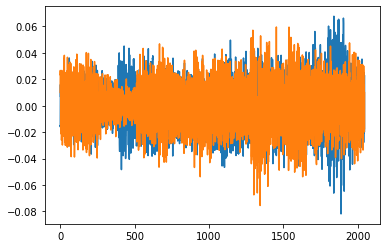

In [50]:
plt.plot(V1)
plt.plot(V2)

In [62]:
from sklearn.metrics import pairwise_distances

In [70]:
np.sum(V1 * V2)

-0.035690289929420395